# Lunar Lander - Actor-Critic Algorithms Comparison
This notebook compares different reinforcement learning algorithms (REINFORCE, A2C variants) on the LunarLander-v2 environment.

In [ ]:
# Cell 1: Install dependencies
!pip install -q Box2D gymnasium torch matplotlib seaborn pandas rich

# Note: If Colab kernel restarts after installs, re-run next cells.

## 1. Install Dependencies

In [ ]:
# Cell 2: Imports and utilities
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical, Normal

import numpy as np
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from collections import deque
from datetime import datetime
from typing import List, Tuple, Dict

sns.set(style="darkgrid", context="notebook", rc={"figure.figsize": (10,6)})
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Make directories
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

# Small RNG seed for reproducibility in examples
GLOBAL_SEED = 42
torch.manual_seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

## 2. Imports and Utilities

In [ ]:
# Cell 3: Network definitions (discrete-friendly)
class ActorNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
    def forward(self, x):
        return self.net(x)  # logits

class CriticNet(nn.Module):
    def __init__(self, state_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)  # scalar value

class SharedActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU()
        )
        self.actor = nn.Linear(hidden_dim, action_dim)
        self.critic = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        h = self.shared(x)
        logits = self.actor(h)
        value = self.critic(h).squeeze(-1)
        return logits, value

## 3. Neural Network Architectures

In [ ]:
# Cell 4: REINFORCE (Monte Carlo) - discrete action
class REINFORCEAgent:
    def __init__(self, state_dim, action_dim, lr=3e-4, gamma=0.99, hidden=256, entropy_coef=0.01, max_grad_norm=0.5):
        self.gamma = gamma
        self.entropy_coef = entropy_coef
        self.max_grad_norm = max_grad_norm

        self.policy = ActorNet(state_dim, action_dim, hidden).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)

    def select_action(self, state):
        s = torch.FloatTensor(state).to(device)
        logits = self.policy(s)
        dist = Categorical(logits=logits)
        a = dist.sample()
        return a.item(), dist.log_prob(a), dist.entropy()

    def compute_returns(self, rewards: List[float]):
        returns = []
        R = 0.0
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns, dtype=torch.float32, device=device)
        # normalize for stability
        if returns.std() > 1e-6:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        return returns

    def update(self, log_probs: List[torch.Tensor], entropies: List[torch.Tensor], rewards: List[float]):
        returns = self.compute_returns(rewards)
        policy_loss = 0
        for lp, R, ent in zip(log_probs, returns, entropies):
            policy_loss = policy_loss - lp * R - self.entropy_coef * ent
        policy_loss = policy_loss / max(1, len(log_probs))

        self.optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), max_norm=self.max_grad_norm)
        self.optimizer.step()
        return policy_loss.item()

## 4. REINFORCE Algorithm

In [ ]:
# Cell 5: A2C with separate networks
class A2CSeparateAgent:
    def __init__(self, state_dim, action_dim, lr=7e-4, gamma=0.99, hidden=256, entropy_coef=0.01, value_coef=0.5, max_grad_norm=0.5):
        self.gamma = gamma
        self.entropy_coef = entropy_coef
        self.value_coef = value_coef
        self.max_grad_norm = max_grad_norm

        self.actor = ActorNet(state_dim, action_dim, hidden).to(device)
        self.critic = CriticNet(state_dim, hidden).to(device)

        self.actor_opt = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_opt = optim.Adam(self.critic.parameters(), lr=lr)

    def select_action(self, state):
        s = torch.FloatTensor(state).to(device)
        logits = self.actor(s)
        dist = Categorical(logits=logits)
        a = dist.sample()
        return a.item(), dist.log_prob(a), dist.entropy(), self.critic(s).item()

    def compute_returns_and_advantages(self, rewards: List[float], values: List[float], next_value: float, gae_lambda: float = None):
        # Simple n-step returns (Monte Carlo for episode) and advantages (returns - values)
        returns = []
        R = next_value
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns, dtype=torch.float32, device=device)
        values_tensor = torch.tensor(values, dtype=torch.float32, device=device)
        advantages = returns - values_tensor
        if advantages.std() > 1e-6:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        return returns, advantages

    def update(self, log_probs: List[torch.Tensor], entropies: List[torch.Tensor], values: List[float], rewards: List[float], next_value: float):
        if len(log_probs) == 0:
            return 0.0, 0.0
        returns, advantages = self.compute_returns_and_advantages(rewards, values, next_value)

        # Critic update
        values_pred = torch.tensor(values, dtype=torch.float32, device=device)
        critic_loss = F.mse_loss(values_pred, returns)
        self.critic_opt.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=self.max_grad_norm)
        self.critic_opt.step()

        # Actor update
        actor_loss = 0
        for lp, adv, ent in zip(log_probs, advantages, entropies):
            actor_loss = actor_loss - lp * adv - self.entropy_coef * ent
        actor_loss = actor_loss / len(log_probs)

        self.actor_opt.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=self.max_grad_norm)
        self.actor_opt.step()

        return actor_loss.item(), critic_loss.item()

## 5. A2C with Separate Networks

In [ ]:
# Cell 5: A2C with separate networks
class A2CSeparateAgent:
    def __init__(self, state_dim, action_dim, lr=7e-4, gamma=0.99, hidden=256, entropy_coef=0.01, value_coef=0.5, max_grad_norm=0.5):
        self.gamma = gamma
        self.entropy_coef = entropy_coef
        self.value_coef = value_coef
        self.max_grad_norm = max_grad_norm

        # Actor and Critic networks
        self.actor = ActorNet(state_dim, action_dim, hidden).to(device)
        self.critic = CriticNet(state_dim, hidden).to(device)

        # Optimizers
        self.actor_opt = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_opt = optim.Adam(self.critic.parameters(), lr=lr)

    def select_action(self, state):
        s = torch.FloatTensor(state).to(device)
        logits = self.actor(s)
        dist = Categorical(logits=logits)
        a = dist.sample()
        # Return action, log_prob, entropy, and value (as float)
        return a.item(), dist.log_prob(a), dist.entropy(), self.critic(s).item()

    def compute_returns_and_advantages(self, rewards: list, values: list, next_value: float, gae_lambda: float = None):
        # Monte Carlo n-step returns and advantages
        returns = []
        R = next_value
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns, dtype=torch.float32, device=device)
        values_tensor = torch.tensor(values, dtype=torch.float32, device=device)
        advantages = returns - values_tensor

        # Normalize advantages
        if advantages.std() > 1e-6:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        return returns, advantages

    def update(self, log_probs: list, entropies: list, values: list, rewards: list, next_value: float):
        if len(log_probs) == 0:
            return 0.0, 0.0

        # Compute returns and advantages
        returns, advantages = self.compute_returns_and_advantages(rewards, values, next_value)

        # Critic update
        values_pred = torch.tensor(values, dtype=torch.float32, device=device, requires_grad=True)
        critic_loss = F.mse_loss(values_pred, returns)
        self.critic_opt.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=self.max_grad_norm)
        self.critic_opt.step()

        # Actor update
        actor_loss = 0
        for lp, adv, ent in zip(log_probs, advantages, entropies):
            actor_loss = actor_loss - lp * adv - self.entropy_coef * ent
        actor_loss = actor_loss / len(log_probs)

        self.actor_opt.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=self.max_grad_norm)
        self.actor_opt.step()

        return actor_loss.item(), critic_loss.item()

## 6. A2C with Shared Networks

In [ ]:
# Cell 6: A2C with shared actor-critic
class A2CSharedAgent:
    def __init__(self, state_dim, action_dim, lr=7e-4, gamma=0.99, hidden=256, entropy_coef=0.01, value_coef=0.5, max_grad_norm=0.5):
        self.gamma = gamma
        self.entropy_coef = entropy_coef
        self.value_coef = value_coef
        self.max_grad_norm = max_grad_norm

        self.net = SharedActorCritic(state_dim, action_dim, hidden).to(device)
        self.opt = optim.Adam(self.net.parameters(), lr=lr)

    def select_action(self, state):
        s = torch.FloatTensor(state).to(device)
        logits, value = self.net(s)
        dist = Categorical(logits=logits)
        a = dist.sample()
        return a.item(), dist.log_prob(a), dist.entropy(), value.item()

    def compute_returns_and_advantages(self, rewards: List[float], values: List[float], next_value: float, gae_lambda: float = None):
        returns = []
        R = next_value
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns, dtype=torch.float32, device=device)
        values_tensor = torch.tensor(values, dtype=torch.float32, device=device)
        advantages = returns - values_tensor
        if advantages.std() > 1e-6:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        return returns, advantages

    def update(self, log_probs: List[torch.Tensor], entropies: List[torch.Tensor], values: List[float], rewards: List[float], next_value: float):
        if len(log_probs) == 0:
            return 0.0, 0.0
        returns, advantages = self.compute_returns_and_advantages(rewards, values, next_value)

        # Value loss
        values_pred = torch.tensor(values, dtype=torch.float32, device=device)
        value_loss = F.mse_loss(values_pred, returns)

        # Policy loss
        policy_loss = 0
        for lp, adv, ent in zip(log_probs, advantages, entropies):
            policy_loss = policy_loss - lp * adv - self.entropy_coef * ent
        policy_loss = policy_loss / len(log_probs)

        loss = policy_loss + self.value_coef * value_loss

        self.opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.net.parameters(), max_norm=self.max_grad_norm)
        self.opt.step()

        return policy_loss.item(), value_loss.item()

## 7. A2C with Generalized Advantage Estimation (GAE)

In [ ]:
# Cell 7: A2C with GAE - CORRECTED VERSION
class A2CGAEAgent:
    def __init__(self, state_dim, action_dim, lr=7e-4, gamma=0.99, gae_lambda=0.95, hidden=256, entropy_coef=0.01, value_coef=0.5, max_grad_norm=0.5):
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.entropy_coef = entropy_coef
        self.value_coef = value_coef
        self.max_grad_norm = max_grad_norm

        self.actor = ActorNet(state_dim, action_dim, hidden).to(device)
        self.critic = CriticNet(state_dim, hidden).to(device)

        self.actor_opt = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_opt = optim.Adam(self.critic.parameters(), lr=lr)

    def select_action(self, state):
        s = torch.FloatTensor(state).to(device)
        
        # Actor forward - with gradients
        logits = self.actor(s)
        dist = Categorical(logits=logits)
        a = dist.sample()
        log_prob = dist.log_prob(a)
        entropy = dist.entropy()
        
        # Critic forward - with gradients  
        value = self.critic(s)
        
        return a.item(), log_prob, entropy, value.squeeze()

    def compute_gae(self, rewards: List[float], values: List[torch.Tensor], next_value: torch.Tensor):
        """Compute Generalized Advantage Estimation"""
        values_extended = values + [next_value]
        gae = 0.0
        advantages = []
        
        for t in reversed(range(len(rewards))):
            # Extract scalar values for GAE computation
            value_t = values[t].item() if hasattr(values[t], 'item') else values[t]
            value_t1 = values_extended[t+1].item() if hasattr(values_extended[t+1], 'item') else values_extended[t+1]
            
            delta = rewards[t] + self.gamma * value_t1 - value_t
            gae = delta + self.gamma * self.gae_lambda * gae
            advantages.insert(0, gae)
        
        advantages_tensor = torch.tensor(advantages, dtype=torch.float32, device=device)
        
        # Compute returns from advantages and original values
        returns = []
        for adv, val in zip(advantages, values):
            val_scalar = val.item() if hasattr(val, 'item') else val
            returns.append(adv + val_scalar)
        returns_tensor = torch.tensor(returns, dtype=torch.float32, device=device)
        
        # Normalize advantages
        if len(advantages) > 1 and advantages_tensor.std() > 1e-6:
            advantages_tensor = (advantages_tensor - advantages_tensor.mean()) / (advantages_tensor.std() + 1e-8)
            
        return advantages_tensor, returns_tensor

    def update(self, log_probs: List[torch.Tensor], entropies: List[torch.Tensor], values: List[torch.Tensor], rewards: List[float], next_value: torch.Tensor):
        if len(log_probs) == 0:
            return 0.0, 0.0
            
        # Stack all tensors to maintain computation graph
        log_probs_tensor = torch.stack(log_probs)
        entropies_tensor = torch.stack(entropies)
        values_tensor = torch.stack(values)
        
        # Compute GAE and returns
        advantages, returns = self.compute_gae(rewards, values, next_value)
        
        # CRITIC UPDATE
        critic_loss = F.mse_loss(values_tensor, returns.detach())
        self.critic_opt.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=self.max_grad_norm)
        self.critic_opt.step()
        
        # ACTOR UPDATE
        policy_loss = -(log_probs_tensor * advantages.detach()).mean()
        entropy_loss = -entropies_tensor.mean()
        actor_loss = policy_loss + self.entropy_coef * entropy_loss
        
        self.actor_opt.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=self.max_grad_norm)
        self.actor_opt.step()

        return actor_loss.item(), critic_loss.item()

## 8. Training Helper Functions

In [ ]:
# Cell 8: Training helpers
def run_episode(env, agent, max_steps=1000):
    obs, _ = env.reset()
    done = False
    total_reward = 0.0
    steps = 0

    states, actions, log_probs, entropies, rewards, values = [], [], [], [], [], []

    while not done and steps < max_steps:
        out = agent.select_action(obs)
        if len(out) == 4:
            a, logp, ent, value = out
        elif len(out) == 3:
            a, logp, ent = out
            value = None
        else:
            raise ValueError(f"select_action returned {len(out)} values. Expected 3 or 4.")

        obs_new, r, done, truncated, info = env.step(a)

        states.append(obs)
        actions.append(a)
        log_probs.append(logp)
        entropies.append(ent)
        rewards.append(r)
        if value is not None:
            values.append(value)

        total_reward += r
        steps += 1
        obs = obs_new

    # next value for bootstrapping
    if not done and hasattr(agent, "select_action"):
        out = agent.select_action(obs)
        next_value = out[3] if len(out) == 4 else 0.0
    else:
        next_value = 0.0

    return total_reward, steps, states, actions, log_probs, entropies, rewards, values, next_value


def evaluate_agent(env, agent, episodes=10, render=False):
    returns = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        total = 0.0
        while not done:
            a, _, _, _ = agent.select_action(obs)
            obs, r, done, truncated, info = env.step(a)
            total += r
            if render:
                env.render()
        returns.append(total)
    return np.mean(returns), np.std(returns)

## 9. Unified Training Loop

In [ ]:
# Cell 9: Unified trainer
def train_agent(env_name: str,
                algorithm_name: str,
                num_episodes: int = 1200,
                max_steps: int = 1000,
                save_best: bool = True,
                verbose: bool = True,
                early_stop_avg_window: int = 100,
                target_solved_reward: float = 200.0):
    """
    algorithm_name: one of 'REINFORCE', 'A2C_Separate', 'A2C_Shared', 'A2C_GAE'
    """
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    # Discrete
    if isinstance(env.action_space, gym.spaces.Discrete):
        action_dim = env.action_space.n
    else:
        raise NotImplementedError("This notebook specialized for discrete LunarLander-v2")

    # Instantiate correct agent
    if algorithm_name == "REINFORCE":
        agent = REINFORCEAgent(state_dim, action_dim, lr=3e-4, gamma=0.99, hidden=256, entropy_coef=0.01)
    elif algorithm_name == "A2C_Separate":
        agent = A2CSeparateAgent(state_dim, action_dim, lr=7e-4, gamma=0.99, hidden=256, entropy_coef=0.01, value_coef=0.5)
    elif algorithm_name == "A2C_Shared":
        agent = A2CSharedAgent(state_dim, action_dim, lr=7e-4, gamma=0.99, hidden=256, entropy_coef=0.01, value_coef=0.5)
    elif algorithm_name == "A2C_GAE":
        agent = A2CGAEAgent(state_dim, action_dim, lr=7e-4, gamma=0.99, gae_lambda=0.95, hidden=256, entropy_coef=0.01, value_coef=0.5)
    else:
        raise ValueError("Unknown algorithm")

    history = {
        'returns': [],
        'lengths': [],
        'losses': [],
        'times': []
    }

    best_avg = -np.inf
    best_model_path = os.path.join("models", f"{env_name}_{algorithm_name}_best.pth")
    start_time = time.time()

    reward_deque = deque(maxlen=early_stop_avg_window)

    for ep in range(1, num_episodes+1):
        ep_start = time.time()
        # collect full episode
        total, steps, states, actions, log_probs, entropies, rewards, values, next_value = run_episode(env, agent, max_steps=max_steps)

        # update agent depending on algorithm
        if algorithm_name == "REINFORCE":
            loss = agent.update(log_probs, entropies, rewards)
            history['losses'].append(loss)
        elif algorithm_name == "A2C_Separate":
            actor_loss, critic_loss = agent.update(log_probs, entropies, values, rewards, next_value)
            history['losses'].append(actor_loss + critic_loss)
        elif algorithm_name == "A2C_Shared":
            pol_loss, val_loss = agent.update(log_probs, entropies, values, rewards, next_value)
            history['losses'].append(pol_loss + val_loss)
        elif algorithm_name == "A2C_GAE":
            actor_loss, critic_loss = agent.update(log_probs, entropies, values, rewards, next_value)
            history['losses'].append(actor_loss + critic_loss)

        ep_time = time.time() - ep_start
        history['returns'].append(total)
        history['lengths'].append(steps)
        history['times'].append(ep_time)
        reward_deque.append(total)

        # save best model based on moving average
        moving_avg = np.mean(list(reward_deque)) if len(reward_deque) > 0 else total
        if save_best and moving_avg > best_avg:
            best_avg = moving_avg
            # Save state dict depending on agent type
            try:
                torch.save(agent.__dict__, best_model_path)  # fallback: save agent internal dict
            except Exception:
                # simpler save: save individual networks if exist
                try:
                    if hasattr(agent, 'policy'):
                        torch.save(agent.policy.state_dict(), best_model_path)
                    elif hasattr(agent, 'actor') and hasattr(agent, 'critic'):
                        torch.save({'actor': agent.actor.state_dict(), 'critic': agent.critic.state_dict()}, best_model_path)
                    elif hasattr(agent, 'net'):
                        torch.save(agent.net.state_dict(), best_model_path)
                except Exception as e:
                    print("Warning: could not save model:", e)

        # verbose printing
        if verbose and (ep % max(1, num_episodes//20) == 0 or ep <= 10):
            print(f"[{algorithm_name}] Ep {ep}/{num_episodes} | Return: {total:.2f} | MA({early_stop_avg_window}): {moving_avg:.2f}")

        # early stopping when solved consistently
        if len(reward_deque) == early_stop_avg_window and moving_avg >= target_solved_reward:
            print(f"[{algorithm_name}] Solved at episode {ep} with moving avg {moving_avg:.2f}!")
            break

    total_time = time.time() - start_time
    env.close()

    # compute summary stats
    arr = np.array(history['returns'])
    summary = {
        'final_return': float(arr[-1]),
        'mean_last_50': float(np.mean(arr[-50:])) if len(arr) >= 1 else float(np.nan),
        'std_last_50': float(np.std(arr[-50:])) if len(arr) >= 1 else float(np.nan),
        'episodes_trained': len(arr),
        'training_time_s': total_time,
        'convergence_episode': None
    }

    # compute convergence episode (first episode where moving avg (window 100) >= target_solved_reward)
    if len(arr) >= 1:
        ma = pd.Series(arr).rolling(early_stop_avg_window, min_periods=1).mean()
        solved_idx = np.where(ma >= target_solved_reward)[0]
        if len(solved_idx) > 0:
            summary['convergence_episode'] = int(solved_idx[0]) + 1
        else:
            summary['convergence_episode'] = None

    # save history as CSV
    hist_df = pd.DataFrame(history)
    hist_df.to_csv(os.path.join("results", f"{env_name}_{algorithm_name}_history.csv"), index=False)

    return summary, history, best_model_path

## 10. Train REINFORCE Agent

In [ ]:
# Train REINFORCE
ENV_NAME = "LunarLander-v2"
NUM_EPISODES = 1200

print("="*80)
print("Training: REINFORCE")

summary_reinforce, history_reinforce, best_path_reinforce = train_agent(
    ENV_NAME, algorithm_name="REINFORCE", num_episodes=NUM_EPISODES, save_best=True, verbose=True
)

summary_reinforce['algorithm'] = "REINFORCE"

HISTORIES = {"REINFORCE": history_reinforce}
BEST_MODELS = {"REINFORCE": best_path_reinforce}

# Convert to DataFrame and save
summary_df_reinforce = pd.DataFrame([summary_reinforce])
summary_df_reinforce = summary_df_reinforce[['algorithm','final_return','mean_last_50','std_last_50','episodes_trained','training_time_s','convergence_episode']]
summary_df_reinforce.to_csv(os.path.join("results", f"{ENV_NAME}_REINFORCE_summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"), index=False)
summary_df_reinforce

## 11. Train A2C with Separate Networks

In [ ]:
# Train A2C_Separate
print("="*80)
print("Training: A2C_Separate")

summary_a2c_sep, history_a2c_sep, best_path_a2c_sep = train_agent(
    ENV_NAME, algorithm_name="A2C_Separate", num_episodes=NUM_EPISODES, save_best=True, verbose=True
)

summary_a2c_sep['algorithm'] = "A2C_Separate"

HISTORIES["A2C_Separate"] = history_a2c_sep
BEST_MODELS["A2C_Separate"] = best_path_a2c_sep

summary_df_a2c_sep = pd.DataFrame([summary_a2c_sep])
summary_df_a2c_sep = summary_df_a2c_sep[['algorithm','final_return','mean_last_50','std_last_50','episodes_trained','training_time_s','convergence_episode']]
summary_df_a2c_sep.to_csv(os.path.join("results", f"{ENV_NAME}_A2C_Separate_summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"), index=False)
summary_df_a2c_sep

## 12. Train A2C with Shared Networks

In [ ]:
# Train A2C_Shared
print("="*80)
print("Training: A2C_Shared")

summary_a2c_shared, history_a2c_shared, best_path_a2c_shared = train_agent(
    ENV_NAME, algorithm_name="A2C_Shared", num_episodes=NUM_EPISODES, save_best=True, verbose=True
)

summary_a2c_shared['algorithm'] = "A2C_Shared"

HISTORIES["A2C_Shared"] = history_a2c_shared
BEST_MODELS["A2C_Shared"] = best_path_a2c_shared

summary_df_a2c_shared = pd.DataFrame([summary_a2c_shared])
summary_df_a2c_shared = summary_df_a2c_shared[['algorithm','final_return','mean_last_50','std_last_50','episodes_trained','training_time_s','convergence_episode']]
summary_df_a2c_shared.to_csv(os.path.join("results", f"{ENV_NAME}_A2C_Shared_summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"), index=False)
summary_df_a2c_shared

## 13. Train A2C with GAE

In [ ]:
# Train A2C_GAE
print("="*80)
print("Training: A2C_GAE")

summary_a2c_gae, history_a2c_gae, best_path_a2c_gae = train_agent(
    ENV_NAME, algorithm_name="A2C_GAE", num_episodes=NUM_EPISODES, save_best=True, verbose=True
)

summary_a2c_gae['algorithm'] = "A2C_GAE"

HISTORIES["A2C_GAE"] = history_a2c_gae
BEST_MODELS["A2C_GAE"] = best_path_a2c_gae

summary_df_a2c_gae = pd.DataFrame([summary_a2c_gae])
summary_df_a2c_gae = summary_df_a2c_gae[['algorithm','final_return','mean_last_50','std_last_50','episodes_trained','training_time_s','convergence_episode']]
summary_df_a2c_gae.to_csv(os.path.join("results", f"{ENV_NAME}_A2C_GAE_summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"), index=False)
summary_df_a2c_gae

## 14. Visualize Reward Curves

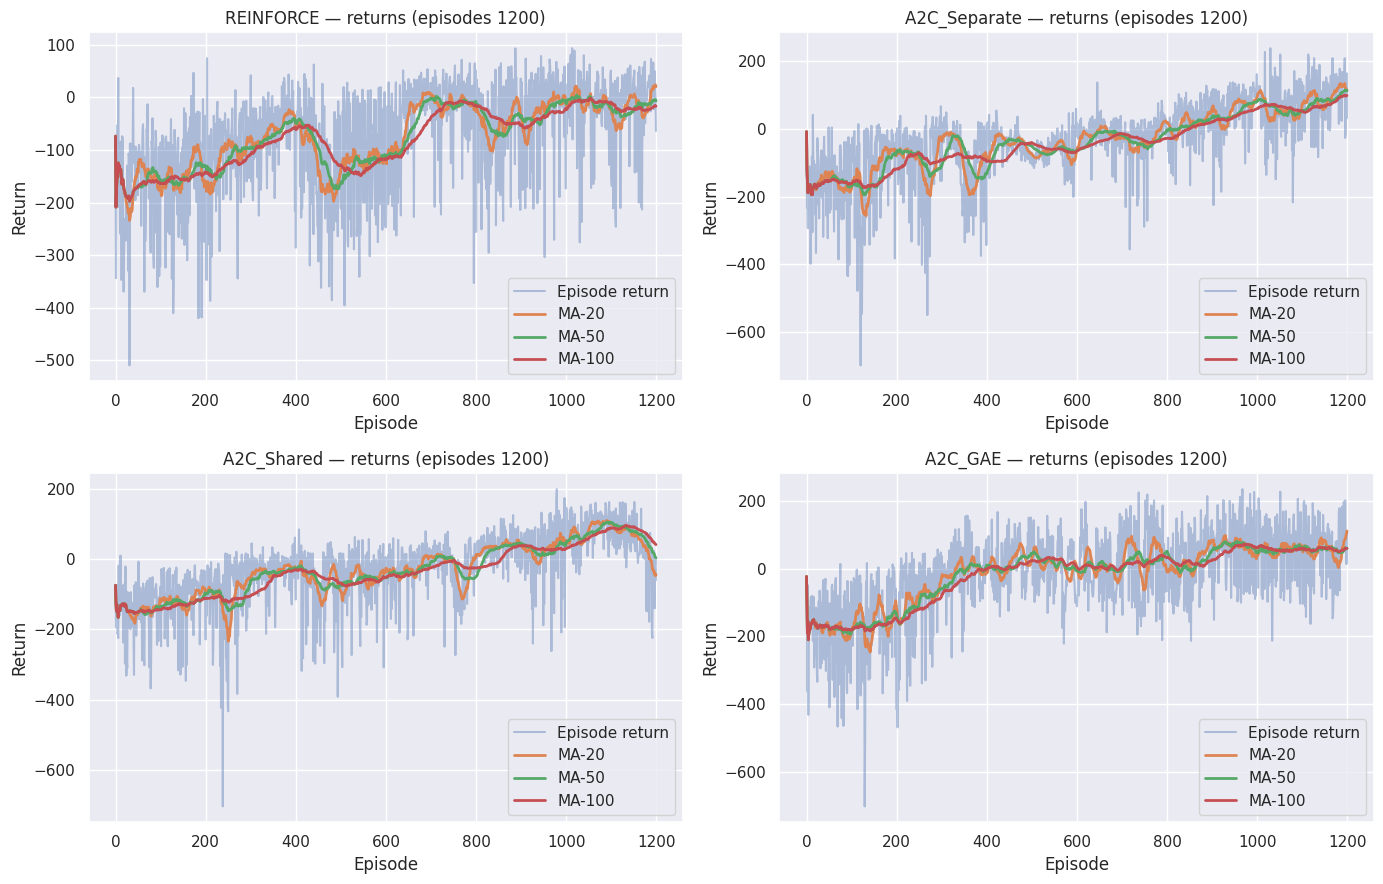

In [34]:
# Cell 11: Reward curves and moving averages
plt.figure(figsize=(14, 9))
n_cols = 2
n_rows = int(np.ceil(len(HISTORIES) / n_cols))

for i, (algo, history) in enumerate(HISTORIES.items(), 1):
    plt.subplot(n_rows, n_cols, i)
    returns = np.array(history['returns'])
    plt.plot(returns, alpha=0.4, label='Episode return')
    # moving averages
    for w in [20, 50, 100]:
        ma = pd.Series(returns).rolling(window=w, min_periods=1).mean()
        plt.plot(ma, label=f"MA-{w}", linewidth=2)
    plt.title(f"{algo} — returns (episodes {len(returns)})")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.legend()
plt.tight_layout()
plt.savefig(os.path.join("results", f"{ENV_NAME}_reward_curves.png"), dpi=150, bbox_inches='tight')
plt.show()

## 15. Comprehensive Performance Comparison

In [36]:
# Combine all summaries
all_summaries = [summary_reinforce, summary_a2c_sep, summary_a2c_shared, summary_a2c_gae]
summary_df = pd.DataFrame(all_summaries)

print("\n" + "="*120)
print("LUNARLANDER-V2: COMPREHENSIVE PERFORMANCE COMPARISON")
print("="*120 + "\n")

# -----------------------------------------------
# TABLE 1 : MAIN PERFORMANCE METRICS
# -----------------------------------------------
print("📈 TABLE 1: MAIN PERFORMANCE METRICS (Last 50 Episodes)")
print("-"*120)

perf_table = summary_df[['algorithm', 'final_return', 'mean_last_50', 'std_last_50', 'episodes_trained']].copy()
perf_table.columns = ['Algorithm', 'Final Return', 'Mean (Last 50)', 'Std Dev', 'Episodes Trained']

# Formatting numbers
perf_table['Final Return'] = perf_table['Final Return'].apply(lambda x: f"{x:.2f}")
perf_table['Mean (Last 50)'] = perf_table['Mean (Last 50)'].apply(lambda x: f"{x:.2f}")
perf_table['Std Dev'] = perf_table['Std Dev'].apply(lambda x: f"{x:.2f}")

print(tabulate(perf_table, headers='keys', tablefmt='fancy_grid', showindex=False))


# -----------------------------------------------
# TABLE 2 : CONVERGENCE ANALYSIS
# -----------------------------------------------
print("\n\n🎯 TABLE 2: CONVERGENCE ANALYSIS")
print("-"*120)

conv_table = summary_df[['algorithm', 'convergence_episode', 'episodes_trained', 'training_time_s']].copy()
conv_table.columns = ['Algorithm', 'Conv. Episode', 'Total Episodes', 'Training Time (s)']

conv_table['Conv. Episode'] = conv_table['Conv. Episode'].apply(lambda x: f"{int(x)}" if not pd.isna(x) else "Never")
conv_table['Training Time (s)'] = conv_table['Training Time (s)'].apply(lambda x: f"{x:.1f}")

print(tabulate(conv_table, headers='keys', tablefmt='fancy_grid', showindex=False))


# -----------------------------------------------
# TABLE 3 : RANKING
# -----------------------------------------------
print("\n\n🏆 TABLE 3: ALGORITHM RANKING")
print("-"*120)

ranking = summary_df[['algorithm', 'mean_last_50']].copy()
ranking['Rank'] = ranking['mean_last_50'].rank(ascending=False).astype(int)
ranking = ranking.sort_values('Rank')
ranking.columns = ['Algorithm', 'Mean Return (Last 50)', 'Rank']

ranking['Mean Return (Last 50)'] = ranking['Mean Return (Last 50)'].apply(lambda x: f"{x:.2f}")

print(tabulate(ranking, headers='keys', tablefmt='fancy_grid', showindex=False))


# -----------------------------------------------
# SUMMARY STATISTICS
# -----------------------------------------------
print("\n\n📊 SUMMARY STATISTICS")
print("-"*120)

best_algo = summary_df.loc[summary_df['mean_last_50'].idxmax(), 'algorithm']
best_return = summary_df['mean_last_50'].max()

worst_algo = summary_df.loc[summary_df['mean_last_50'].idxmin(), 'algorithm']
worst_return = summary_df['mean_last_50'].min()

avg_all = summary_df['mean_last_50'].mean()

fastest_algo = summary_df.loc[summary_df['training_time_s'].idxmin(), 'algorithm']
fastest_time = summary_df['training_time_s'].min()

print(f"✅ Best Algorithm:    {best_algo:<20} Mean Return: {best_return:.2f}")
print(f"⚠️  Worst Algorithm:   {worst_algo:<20} Mean Return: {worst_return:.2f}")
print(f"📈 Average (All):     Mean Return: {avg_all:.2f}")
print(f"⚡ Fastest Training:  {fastest_algo:<20} Time: {fastest_time:.1f}s")
print(f"📍 Performance Gap:   {best_return - worst_return:.2f} "
      f"({100*(best_return - worst_return)/abs(worst_return):.1f}% improvement)")

print("\n" + "="*120 + "\n")



LUNARLANDER-V2: COMPREHENSIVE PERFORMANCE COMPARISON

📈 TABLE 1: MAIN PERFORMANCE METRICS (Last 50 Episodes)
------------------------------------------------------------------------------------------------------------------------
╒══════════════╤════════════════╤══════════════════╤═══════════╤════════════════════╕
│ Algorithm    │   Final Return │   Mean (Last 50) │   Std Dev │   Episodes Trained │
╞══════════════╪════════════════╪══════════════════╪═══════════╪════════════════════╡
│ REINFORCE    │         -63.84 │            -6.65 │     67.7  │               1200 │
├──────────────┼────────────────┼──────────────────┼───────────┼────────────────────┤
│ A2C_Separate │         164.77 │           114.09 │     56.87 │               1200 │
├──────────────┼────────────────┼──────────────────┼───────────┼────────────────────┤
│ A2C_Shared   │          -2.39 │             3.78 │     79.7  │               1200 │
├──────────────┼────────────────┼──────────────────┼───────────┼─────────────────